Import data and libraries

In [13]:
import pandas as pd
coralDiseases = pd.read_csv('HICORDIS_Disease_Prevalences.csv') # read csv

In [14]:
import datetime
coralDiseases['Year'] = pd.DatetimeIndex(coralDiseases['Date']).year # make vector of survey year

Define outbreak thresholds

In [15]:
import numpy as np
import heapq
cDiseases = coralDiseases.copy(deep=True) # make duplicate dataset
timeSpan = range(2004,2016) # define vector of years 2004-2015
Diseases = ['Growth_anomalies_Prevalence', 'Tissue_Loss_Prevalence', 'White_Syndrome_Prevalence']

for condition in Diseases:
    maxPrevVector = [] # make vector with zero as the first element
    for year in timeSpan: # for each year in database
        subByYear = coralDiseases[coralDiseases.Year == year] # subset data by year X
        maxPrev = max(subByYear[condition]) # find the max prevalence of year X
        maxPrevVector.extend([maxPrev]) # add max prevalence to vector
    meanPrev = np.mean([maxPrevVector]) # find mean of the vector of maximum prevalence per year
    sdPrev = np.std(maxPrevVector) # find standard deviation of vector
    threshold = meanPrev + sdPrev # define a temporary threshold of mean + 1 standard deviation
    while max(maxPrevVector) > threshold: # until all values in vector is less than the temporary threshold
        for i in maxPrevVector: # for each value in vector
            if i > threshold: # if value is greater than the threshold
                index = maxPrevVector.index(i) # find the location (element) in the vector where the value is greater than the threshold 
                year = timeSpan[index] # use the location in vector to find the year in which the prevalence was higher than the threshold 
                subByYear = cDiseases[cDiseases.Year == year] # subset data by that year
                subByYearUnique = np.unique(subByYear[condition]) # find unique values of prevalences
                secondHighestValue = heapq.nlargest(2, subByYearUnique) # find the second highest value
                if len(secondHighestValue) == 1: # if the vector only has one element
                    cDiseases[condition] = cDiseases[condition].replace([i], secondHighestValue[0]) # replace highest prevalence value with the second highest value
                    newMaxPrev = max(cDiseases[condition]) # find new maximum prevalence value
                    maxPrevVector[index] = newMaxPrev # replace old maximum prevalence value with new max value
                else: # else repeat these steps with the second element of the second highest value vector
                    cDiseases[condition] = cDiseases[condition].replace([i], secondHighestValue[1])
                    newMaxPrev = max(cDiseases[condition])
                    maxPrevVector[index] = newMaxPrev
        meanPrev = np.mean([maxPrevVector])
        sdPrev = np.std(maxPrevVector) 
        threshold = meanPrev + sdPrev
    print "%s = %s threshold" %(threshold, condition) # return threshold values
    coralDiseases['Outbreak_%s' % condition] = np.where( ( (coralDiseases[condition] >= threshold)  ), 1, 0) # create a new binary column indicating outbreak (1) or no outbreak (0)   

16.3438578066 = Growth_anomalies_Prevalence threshold
34.7898484814 = Tissue_Loss_Prevalence threshold
0.44538755766 = White_Syndrome_Prevalence threshold


Create scatterplots

In [18]:
# put pdfs in single canvas
from os import listdir
plotList = listdir("scatterplots")
import matplotlib.pyplot as plt
import pylab
%matplotlib inline 

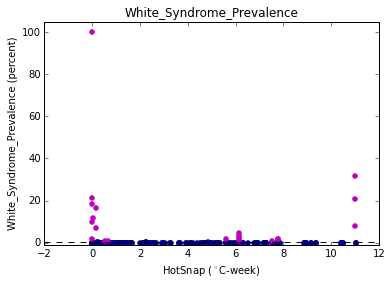

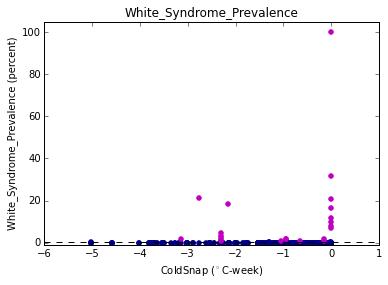

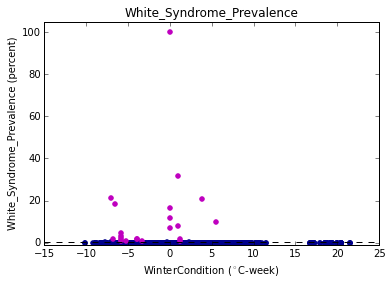

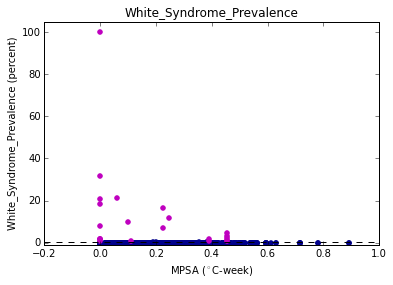

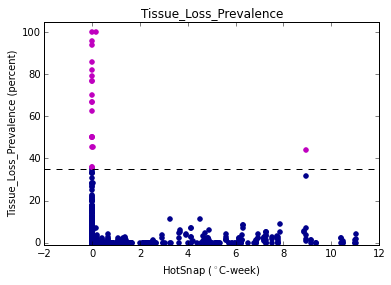

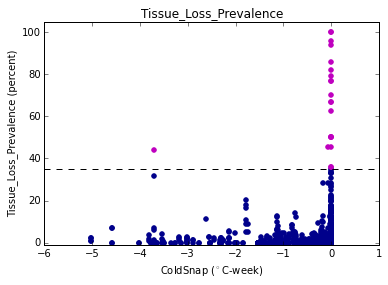

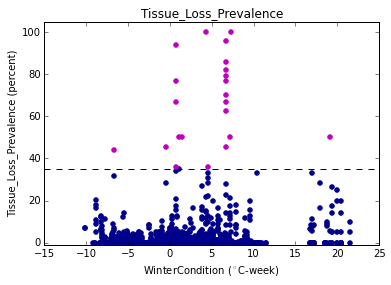

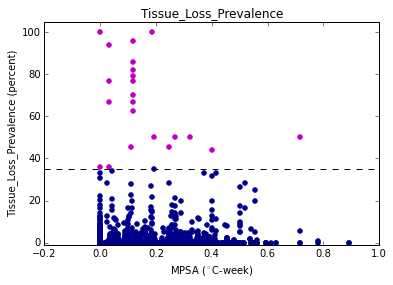

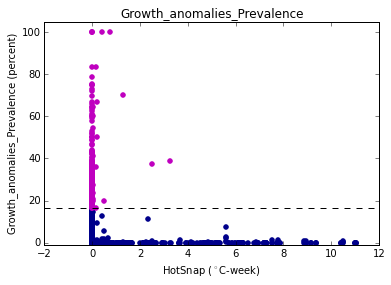

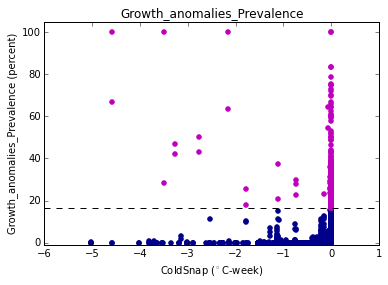

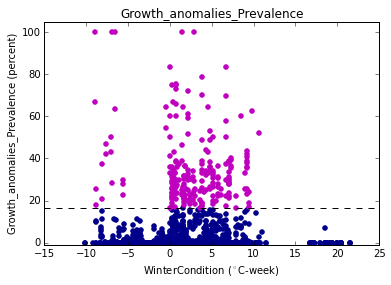

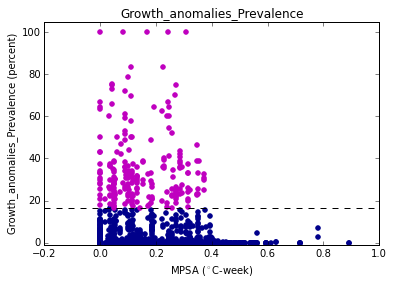

In [102]:
# create scatterplots of sst metrics vs. coral disease prevalences

SSTmetrics = ['HotSnap', 'ColdSnap', 'WinterCondition', 'MPSA']
Diseases = ['White_Syndrome_Prevalence', 'Tissue_Loss_Prevalence', 'Growth_anomalies_Prevalence']

for coralDisease in Diseases: # for all diseases
    if coralDisease == 'Tissue_Loss_Prevalence':
        threshold = 34.7898484814
    elif coralDisease == 'Growth_anomalies_Prevalence':
        threshold = 16.3438578066
    else:
        threshold = 0.44538755766
    for sst in SSTmetrics: # for all sst metrics
        belowThreshold = coralDiseases[coralDiseases[coralDisease] < threshold]
        aboveThreshold = coralDiseases[coralDiseases[coralDisease] >= threshold]
        plt.figure()
        plt.scatter(belowThreshold[sst], belowThreshold[coralDisease], color='darkblue')
        plt.scatter(aboveThreshold[sst], aboveThreshold[coralDisease], color='m')
        plt.axhline(y = threshold, linewidth=1, linestyle='dashed', color = 'k')
        pylab.title(coralDisease) # add plot title
        pylab.xlabel('%s ($^\circ$C-week)' %sst) # add x-axis label
        pylab.ylabel('%s (percent)' %coralDisease) # add y-axis label
        pylab.ylim([-1,105])
        plt.savefig('scatterplots/%s_%s.pdf' %(coralDisease, sst)) # save as png, name according to sst metric & disease type

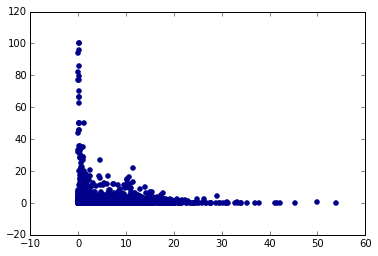

In [24]:
plt.scatter(coralDiseases['Porites_Density'], coralDiseases['Tissue_Loss_Prevalence'], color='darkblue')

In [16]:
# example CART model with iris dataset
import numpy as np
import urllib
# url with dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data"
# download the file
raw_data = urllib.urlopen(url)
# load the CSV file as a numpy matrix
dataset = np.loadtxt(raw_data, delimiter=",")
# separate the data from the target attributes
X = dataset[:,0:7]
y = dataset[:,8]

In [29]:
sstMetrics = coralDiseases[['MPSA', 'HotSnap', 'ColdSnap', 'WinterCondition']]
condition = coralDiseases['Outbreak_Tissue_Loss_Prevalence']

In [30]:
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(sstMetrics, condition)
print(model)
# make predictions
expected = condition
predicted = model.predict(sstMetrics)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')
             precision    recall  f1-score   support

          0       0.99      1.00      1.00      1826
          1       1.00      0.55      0.71        22

avg / total       0.99      0.99      0.99      1848

[[1826    0]
 [  10   12]]


In [35]:
model = DecisionTreeClassifier()
clf = model.fit(sstMetrics, condition)
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data) 
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 
graph.write_pdf("iris.pdf") 

ImportError: No module named pydot

In [39]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
#>>> X = np.random.randn(10, 4)
#>>> y = array(["foo", "bar", "baz"])[np.random.randint(0, 3, 10)]
clf = DecisionTreeClassifier().fit(sstMetrics, condition)
export_graphviz(clf)
dot -Tpng

NameError: name 'dot' is not defined

In [12]:
list(coralDiseases.columns.values) # find column names

['Date',
 'Latitude',
 'Longitude',
 'Region',
 'Island',
 'Site',
 'Transect_Number',
 'Colony_Density',
 'Montipora_Density',
 'Porites_Density',
 'Tissue_Loss_Prevalence',
 'Growth_anomalies_Prevalence',
 'White_Syndrome_Prevalence',
 'sst_lat',
 'sst_lon',
 'DHW_from_HSge1',
 'DHW_from_HSgt0',
 'MPSA',
 'HotSnap',
 'ColdSnap',
 'WinterCondition',
 'Year',
 'Outbreak',
 'Outbreak_Growth_anomalies_Prevalence',
 'Outbreak_Tissue_Loss_Prevalence',
 'Outbreak_White_Syndrome_Prevalence']

In [2]:
# Decision Tree Classifier
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
 
# load the iris datasets
dataset = datasets.load_iris()


In [3]:
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(dataset.data, dataset.target)
print(model)


DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')


In [5]:
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00        50
          2       1.00      1.00      1.00        50

avg / total       1.00      1.00      1.00       150

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]


In [6]:
# Decision Tree Classifier
from sklearn import datasets
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
# load the iris datasets
dataset = datasets.load_iris()
# fit a CART model to the data
model = DecisionTreeClassifier()
model.fit(dataset.data, dataset.target)
print(model)
# make predictions
expected = dataset.target
predicted = model.predict(dataset.data)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

DecisionTreeClassifier(compute_importances=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_density=None, min_samples_leaf=1, min_samples_split=2,
            random_state=None, splitter='best')
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      1.00      1.00        50
          2       1.00      1.00      1.00        50

avg / total       1.00      1.00      1.00       150

[[50  0  0]
 [ 0 50  0]
 [ 0  0 50]]
